In [1]:
%load_ext autoreload
%autoreload 2

import gpytorch
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from LDGD.model import LDGD
from LDGD.model.Autoencoder import VAE
from LDGD.visualization.vizualize_utils import plot_heatmap, plot_2d_scatter, plot_ARD_gplvm
from LDGD.visualization.vizualize_utils import plot_loss_gplvm, plot_scatter_gplvm
from LDGD.data.data_loader import generate_data

from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood

# Settings

In [2]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points': 5,
    'num_epochs_train': 2000,
    'num_epochs_test': 2000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': False,
    'use_gpytorch': True,
    'random_state': 54,
    'test_size': 0.3
}

In [3]:
np.random.seed(model_settings['random_state'])
torch.manual_seed(model_settings['random_state'])


# Create Dataset

In [4]:
def create_dataset(num_dimension, random_state, test_size, **kwargs):
    # Extract parameters for synthetic data generation
    pattern = kwargs.get('pattern', 'moon')  # default pattern
    n_samples = kwargs.get('n_samples', 1000)
    noise = kwargs.get('noise', 0.1)
    increase_method = kwargs.get('increase_method', 'linear')

    X, y, orig_data = generate_data(pattern, n_samples, noise, num_dimension, increase_method, random_state=random_state)
    # One-hot encode the labels
    y_one_hot = np.zeros((y.shape[0], len(np.unique(y))))
    y_one_hot[np.arange(y.shape[0]), np.uint(y)] = 1

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(X, y_one_hot, y,
                                                                                       test_size=test_size,
                                                                                       random_state=random_state)
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    y_train_labels_tensor = torch.tensor(y_train_labels)
    y_test_labels_tensor = torch.tensor(y_test_labels)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_train_labels_tensor, y_test_labels_tensor, orig_data

# Create Model

In [5]:
def create_LDGD_model(ldgd_settings):
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()

    model = LDGD(yn_train,
                 kernel_reg=kernel_reg,
                 kernel_cls=kernel_cls,
                 num_classes=ys_train.shape[-1],
                 latent_dim=ldgd_settings['latent_dim'],
                 num_inducing_points=ldgd_settings['num_inducing_points'],
                 likelihood_reg=likelihood_reg,
                 likelihood_cls=likelihood_cls,
                 shared_inducing_points=ldgd_settings['shared_inducing_points'],
                 use_gpytorch=ldgd_settings['use_gpytorch'],
                 random_state=ldgd_settings['random_state'])
    return model

# Train Model

In [6]:
model_list = []
for num_dimension in [5, 10, 20]:
    yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=num_dimension,
                                                                                                   random_state= model_settings['random_state'],
                                                                                                   test_size=model_settings['test_size'])
    model_settings['data_dim'] = yn_train.shape[-1]
    batch_shape = torch.Size([model_settings['data_dim']])

    model = create_LDGD_model(model_settings)

    losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                              epochs=model_settings['num_epochs_train'],
                                              batch_size=model_settings['batch_size'])

    predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                    epochs=model_settings['num_epochs_test'])

    model_list.append(model)

Epoch 1/2000, Loss: 16.36653709411621, MSE: 0.2850594222545624
Epoch 11/2000, Loss: 15.464956283569336, MSE: 0.24240216612815857
Epoch 21/2000, Loss: 14.477660179138184, MSE: 0.20275063812732697
Epoch 31/2000, Loss: 13.57238483428955, MSE: 0.17038731276988983
Epoch 41/2000, Loss: 12.934309959411621, MSE: 0.14744116365909576
Epoch 51/2000, Loss: 11.838254928588867, MSE: 0.13212619721889496
Epoch 61/2000, Loss: 11.238256454467773, MSE: 0.1209922581911087
Epoch 71/2000, Loss: 10.363104820251465, MSE: 0.11565586924552917
Epoch 81/2000, Loss: 9.806486129760742, MSE: 0.11308669298887253
Epoch 91/2000, Loss: 8.876215934753418, MSE: 0.11154650151729584
Epoch 101/2000, Loss: 8.30913257598877, MSE: 0.11077828705310822
Epoch 111/2000, Loss: 8.051653861999512, MSE: 0.11012502759695053
Epoch 121/2000, Loss: 7.371209144592285, MSE: 0.10969515889883041
Epoch 131/2000, Loss: 6.795962810516357, MSE: 0.10937120020389557
Epoch 141/2000, Loss: 6.407168865203857, MSE: 0.10930667817592621
Epoch 151/2000, Lo

# visualize

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

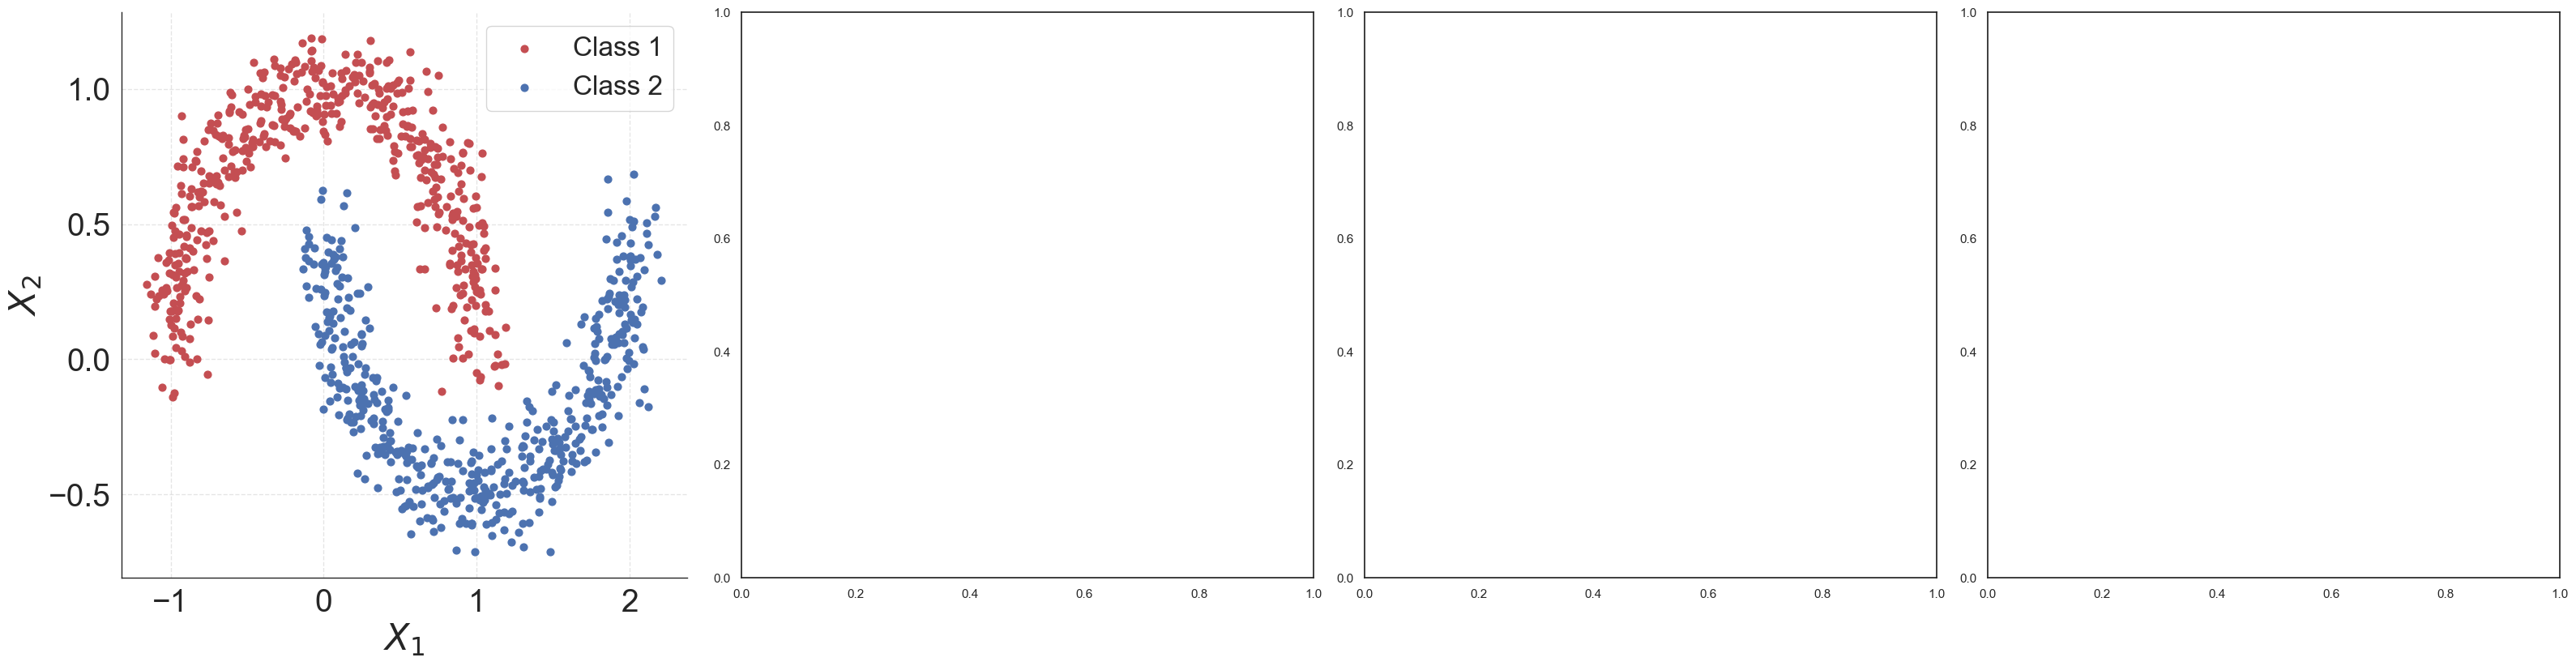

In [7]:
fig, axs = plt.subplots(1,4, figsize=(32, 8))
x_org, y_org = orig_dataset
plot_2d_scatter(x_org, y_org, ax = axs[0])
# [left, bottom, width, height]
for idx , model in enumerate(model_list):
    alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
    alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

    x = model.x.q_mu.cpu().detach().numpy()
    std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

    x_test = model.x_test.q_mu.cpu().detach().numpy()
    std_test = torch.nn.functional.softplus(model.x_test.q_log_sigma).cpu().detach().numpy()

    inducing_points = (history_test['z_list_reg'][-1], history_test['z_list_cls'][-1])

    plot_heatmap(x, labels_train, model, alpha_cls, cmap='winter', range_scale=1.2,
             file_name='latent_heatmap_train', inducing_points=inducing_points, ax1=axs[idx+1], fig=fig)


plt.tight_layout()


# Train Model with larger Latent Dimension

In [ ]:
model_settings = {
    'latent_dim': 10,
    'num_inducing_points': 5,
    'num_epochs_train': 2000,
    'num_epochs_test': 2000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': False,
    'use_gpytorch': True,
    'random_state': 54,
    'test_size': 0.3
}

In [ ]:
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=10,
                                                                                               random_state= model_settings['random_state'],
                                                                                               test_size=model_settings['test_size'])
model_settings['data_dim'] = yn_train.shape[-1]
model_settings['latent_dim'] = 10
batch_shape = torch.Size([model_settings['data_dim']])

model = create_LDGD_model()

losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                          epochs=model_settings['num_epochs_train'],
                                          batch_size=model_settings['batch_size'])

predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                epochs=model_settings['num_epochs_test'])

In [ ]:
alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x = model.x.q_mu.cpu().detach().numpy()
std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

x_test = model.x_test.q_mu.cpu().detach().numpy()
std_test = torch.nn.functional.softplus(model.x_test.q_log_sigma).cpu().detach().numpy()

In [ ]:
latent_dim = x.shape[-1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg, ax=axs[1])
plot_scatter_gplvm(x, labels_train, l1=0, l2=1, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std)
plot_scatter_gplvm(x_test, labels_test, l1=0, l2=1, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test)
plt.tight_layout()


# Compare with VAE
## Settings:

In [ ]:
model_settings = {
    'latent_dim': 10,
    'num_inducing_points': 5,
    'num_epochs_train': 200,
    'num_epochs_test': 200,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': False,
    'use_gpytorch': True,
    'random_state': 54,
    'test_size': 0.3
}

# Training models

In [ ]:
batch_shape = torch.Size([yn_train.shape[-1]])
metric_vae_list, metric_ldgd_list = [], []
for train_size in [10, 100, 1000]:
    yn_train, yn_test, ys_train = yn_train[:train_size], yn_test[:train_size], ys_train[:train_size]

    # Train LDGD Model
    model = create_LDGD_model(model_settings)
    losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                              epochs=model_settings['num_epochs_train'],
                                              batch_size=model_settings['batch_size'])

    predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                    epochs=model_settings['num_epochs_test'])

    # Train VAE Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE(input_dim=yn_train.shape[-1],
                hidden_dim=50,
                latent_dim=2,
                num_classes=len(np.unique(labels_train))).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.fit(x=yn_train, y=labels_train, x_test=yn_test, y_test=labels_test, optimizer=optimizer, epochs=1000, batch_size=500)
    y_hat, mean, log_var, metrics = model.evaluate(yn_test, labels_test)


## Visualize